In [1]:
from distutils.command import config

def random_search(problem, function_evaluations=150, **kwargs):

    history = []
    configs = []

    RANGES = GET_RANGES(problem) 

    for j in range(function_evaluations):
        config={}
        
        for i in RANGES:
            # If there is a condition, check if it holds.
            # If not, skip this hyperparameter
            if(condition(RANGES, config, i)):
                config[i] = math.nan
                continue
            
            a = RANGES[i]['range'][0] 
            b = RANGES[i]['range'][1] 
            
            # If uniform
            if(RANGES[i]['sample']==0):
                if (RANGES[i]["type"] == 0):
                    value=np.random.choice(RANGES[i]['range']) 
                    config[i]=value  
                elif (RANGES[i]["type"] == 1):
                    value=np.random.uniform(a, b) 
                    config[i]=value
                else:
                    value=np.random.randint(a, b+1) 
                    config[i]=value
            # Else log        
            else:
                value=np.random.uniform(np.log(a), np.log(b)) 
                value = np.exp(value)
                if RANGES[i]['type'] == 2:
                    value = round(value)
                config[i]=value # exponentiate value back 
      
        configs.append(config)
        history.append(GET_CONFIG_PERFORMANCE(config, problem))

    return history, configs

# Function for checking if hyperparameter has a condition and whether it holds
def condition(ranges, config, i):
        if('condition' in ranges[i]):
            if (ranges[i]['condition'](config) == False):
                return True

C:\Users\mally\AppData\Local\Temp\ipykernel_28500\3524297253.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.command import config


In [19]:
from utils import GET_CONFIG_PERFORMANCE, GET_RANGES, SampleType, ParamType,normal_dist # make sure to make use of ParamType and SampleType in your code
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.stats import truncnorm
import math
from collections import Counter


# Check if current hyperparameter is active, specifically for nlayers
def condition_check(x_star, i): 
    if 'nlayers' in x_star.keys():
        layers = x_star['nlayers']
        if i[-1].isdigit():
            if int(i[-1]) > layers:
                return True

# n = number of candidate samples
def tpe2(problem, function_evaluations=150, random_warmup=10, gamma=0.5, n=10, **kwargs):

    RANGES = GET_RANGES(problem) 
    
    # Initial warm-up using random search
    loss,configs=random_search(problem,random_warmup)    
    
    hyperparameters = to_df(configs, loss)    
        
    for k in range(function_evaluations):
        
        good_df, bad_df = good_bad(gamma, hyperparameters)
        # Initialize best found configuration
        x_star = {}
        
        # Iterate through each hyperparameter
        for i in good_df.columns.difference(['loss']): 
            # Seperate into good and bad samples
            x = good_df[i].dropna().values.tolist()
            y = bad_df[i].dropna().values.tolist()
            # Add back together for sampling
            full = x + y
            # Define truncation boundaries
            a = RANGES[i]['range'][0]
            b = RANGES[i]['range'][1]
            # Check if current hyperparamter is active    
            if(condition_check(x_star, i)):
                x_star[i] = math.nan
                continue
            
            # If categorical
            if RANGES[i]['type'] == 0:
                samples = sample_uniform(RANGES[i], n)
                # Calculate probability density of the samples
                lx = categorical_pdf(x, samples)
                gx = categorical_pdf(y, samples)
                EI = calculate_EI(lx, gx)
                EI_max = np.argmax(EI)
                value = samples[EI_max]
                x_star[i] = value
                
            else:
                # If sample type is log-unfirom
                if RANGES[i]['sample'] == 1:
                    x = np.log(x)
                    y = np.log(y)
                    full = np.log(full)
                    a, b = np.log(a), np.log(b)
                    
                # Sort because we need the standard deviation to the furthest neighbour
                x.sort()                  
                y.sort()
                full.sort()
                # Calculate sigma for getting the density from the Gaussians
                std_full = scales(full, a, b)
                # Sample from truncated gaussians
                samples = sample_truncnorm(a, b, full, std_full, n)
                # In case l(x) or g(x) does not contain samples: the sigma is 0
                max_sd, max_sd_y = 0, 0
                if len(x) > 0:
                    max_sd = scales(x, a, b)
                if len(y) > 0:
                    max_sd_y = scales(y, a, b)
                # Calculate EI
                EI = get_EI(samples, x, y, a, b, max_sd, max_sd_y, gamma)
                EI_max = np.argmax(EI)
                value = samples[EI_max]
                # If sample type is log-uniform, exponentiate
                if RANGES[i]['sample'] == 1:
                    value = np.exp(value)
                # If hp type is int, round
                if RANGES[i]['type'] == 2:
                    value = round(value)      
                x_star[i] = value
        # Calculate loss and append to observations
        x_star['loss'] = GET_CONFIG_PERFORMANCE(x_star, problem) 
        hyperparameters = hyperparameters.append(x_star, ignore_index=True)            
    # Seperate all found hyperparameters for plotting EI, l(x) and g(x)
    x_final, y_final = good_bad(gamma, hyperparameters)
    EI_plot1 = plot_EI(x_final.iloc[:,0].values,y_final.iloc[:,0].values, a, b, gamma)
    EI_plot2 = plot_EI(x_final.iloc[:,1].values, y_final.iloc[:,1].values, a, b, gamma)
    
    l_x_plot_h1 = pdf_array(x_final.iloc[:,0].values,a,b)
    l_x_plot_h2 = pdf_array(x_final.iloc[:,1].values,a,b)
    g_x_plot_h1 = pdf_array(y_final.iloc[:,0].values,a,b)
    g_x_plot_h2 = pdf_array(y_final.iloc[:,1].values,a,b)
    
    best_hp = hyperparameters.iloc[hyperparameters['loss'].idxmin()]
    return hyperparameters, best_hp, x_final, y_final, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2

# Returns an array with the values for EI
def plot_EI(x, y, a, b, gamma):
    space = np.linspace(a, b, 100)
    l_x = pdf_array(x, a, b)
    g_x = pdf_array(y, a, b)
    # If a value in g(x) == 0, divide by 1
    # So i.e: if a samples hyperparameter is not in g(x), its EI = its pd in l(x)
    g_x[g_x == 0] = 1
    plot = (gamma + (1-gamma)*(l_x/g_x))
    return plot

# Returns an array with the values for a pdf
def pdf_array(x, a, b):
    scales_ = []
    space = np.linspace(a, b, 100)
    scales_ = scales(x, a, b)
    array = np.zeros_like(space)
    # Iterate through each sample
    for i in range(len(x)):
        dist = truncnorm(a, b,loc=x[i], scale=scales_[i])
        # Get pdf values for its truncated Gaussian 
        array += dist.pdf(space)
    return array

# Get EI for a single value of a hyperparameter
def get_EI(samples, x, y, a, b, max_sd, max_sd_y, gamma):
    EI = []
    for j in range(len(samples)):   
        # Set the density to 1, incase l(x) and/or g(x) is zero
        pd_lx = 0
        pd_gx = 1
        if len(x) > 0:
            pd_lx = get_pdf(samples[j], x, a, b, max_sd)     
        if len(y) > 0:
            pd_gx = get_pdf(samples[j], y, a, b, max_sd_y)
        if pd_gx == 0:
            pd_gx = 1
        # Calculate EI
        value = (gamma + (1-gamma)*(pd_lx/pd_gx))
        EI.append(value)
    return EI

def return_node_list(x):
    nodes= []
    for i in x.keys():
        if 'nodes_in_layer' in i:
            nodes.append(x[i])
    return nodes
        
def to_df(configs, loss):

    hyper_parameters=pd.DataFrame(columns=["configs","loss"])
    hyper_parameters["configs"]=configs
    hyper_parameters["loss"]=loss
    
    hyper_parameters_1 = (hyper_parameters["configs"].apply(pd.Series))
    hyper_parameters_1['loss'] = hyper_parameters["loss"]
    
    
    return hyper_parameters_1
            
# Function for dividing samples into good and bad dataframes    
def good_bad(gamma, hyper_parameters):

    sorted_df=(hyper_parameters.sort_values(by=["loss"])).reset_index(drop=True)
    
    index_value=int(gamma*(sorted_df.shape[0]))
    
    good_df = sorted_df.iloc[:index_value]
    bad_df = sorted_df.iloc[index_value:sorted_df.shape[0]]
            
    return good_df, bad_df

def sample_truncnorm(a, b, x, sd, n):
    index = np.random.choice(range(len(x)))
    a, b = (a - x[index]) / sd[index], (b - x[index]) / sd[index]
    samples = stats.truncnorm.rvs(a, b, loc=x[index], scale=sd[index], size=n)
    return samples

def get_pdf(x_i, x, a, b, sd):
    n = len(x)
    total = 0
    
    for i in range(n):
        mean = x[i]
        sigma = sd[i]
        a, b = (a - mean) / sigma, (b - mean) / sigma
        total += stats.truncnorm.pdf(x_i, a, b, loc=mean, scale=sigma)
       # if error == 'error':
       #     print(x_i, a, b, mean, sigma)
        
    return total/n

def scales(x, a, b):
    if len(x) > 1:
        diff = np.diff(x)
    else:
        diff = [0]
    epsilon = (b-a)/min(100,len(x)+2)
    scales = []
    for i in range(0, len(diff)):
        max_ = max(diff[i-1], diff[i], epsilon)
        sigma = min(max_, b-a)
        scales.append(sigma)        
    scales.insert(0,min(max(diff[0], epsilon), b-a))
    scales.insert(-1,min(max(diff[-1], epsilon), b-a))
    
    return scales

def sample_uniform(hyperparameter, n):
    sample = np.random.choice(hyperparameter['range'], n)    
    return sample

def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def categorical_pdf(x, samples):
    n = len(samples)
    c = Counter(x)
    densities = np.zeros(n)
    for i in range(n):
        densities[i] = c[samples[i]]
        
    return densities

def calculate_EI(lx, gx):
    gx[gx < 0.0001] = 0.0001
    EI = lx/gx
    return EI

C:\Users\mally\AppData\Local\Temp\ipykernel_28500\56935090.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))
C:\Users\mally\AppData\Local\Temp\ipykernel_28500\56935090.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))
C:\Users\mally\AppData\Local\Temp\ipykernel_28500\56935090.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))
C:\Users\mally\AppData\Local\Temp\ipykernel_28500\56935090.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))


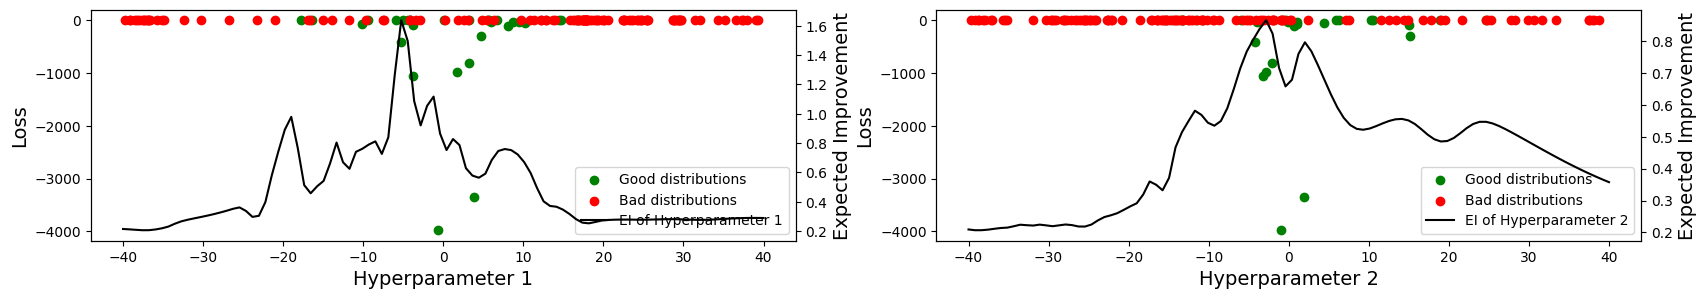

In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df, bp,x, y, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2= tpe2("interactive", function_evaluations = 120, random_warmup = 30, gamma =0.2)

a, b = -40, 40
space = np.linspace(a, b, 100)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,3))
ax[0].scatter(x["hyper1"],x["loss"],color="green",marker="o",label="Good distributions")
ax[0].set_xlabel("Hyperparameter 1", fontsize = 14)
ax[0].set_ylabel("Loss",color="black",fontsize=14)
ax[0].scatter(y["hyper1"],y["loss"],color="red",marker="o",label="Bad distributions")

ax3=ax[0].twinx()
ax3.plot(space, EI_plot1,color="black",label="EI of Hyperparameter 1")
ax3.set_ylabel("Expected Improvement",color="black",fontsize=14)
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='lower right')

ax[1].scatter(x["hyper2"],x["loss"],color="green",marker="o",label="Good distributions")
ax[1].set_xlabel("Hyperparameter 2", fontsize = 14)
ax[1].set_ylabel("Loss",color="black",fontsize=14)
ax[1].scatter(y["hyper2"],y["loss"],color="red",marker="o",label="Bad distributions")

ax3=ax[1].twinx()
ax3.plot(space, EI_plot2,color="black",label="EI of Hyperparameter 2")
ax3.set_ylabel("Expected Improvement",color="black",fontsize=14)
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2, loc='lower right')
plt.show()

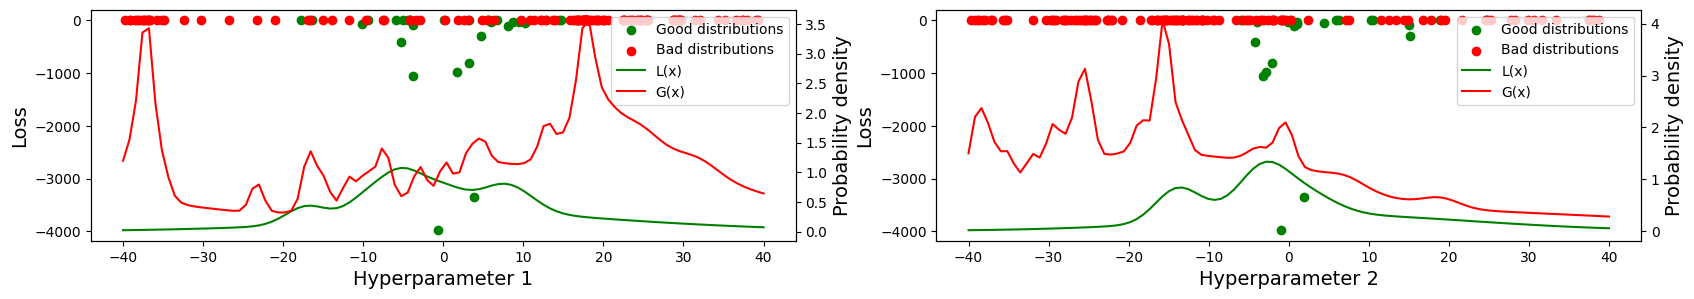

In [42]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,3))
a, b = -40, 40
space = np.linspace(a, b, 100)

ax[0].scatter(x["hyper1"],x["loss"],color="green",marker="o",label="Good distributions")
ax[0].set_xlabel("Hyperparameter 1", fontsize = 14)
ax[0].set_ylabel("Loss",color="black",fontsize=14)
ax[0].scatter(y["hyper1"],y["loss"],color="red",marker="o",label="Bad distributions")
ax3=ax[0].twinx()
ax3.plot(space, l_x_plot_h1,color="green",label="L(x)")
ax3.set_ylabel("L_x",color="black",fontsize=14)
ax3.plot(space, g_x_plot_h1,color="red",label="G(x)")
ax3.set_ylabel("Probability density",color="black",fontsize=14)
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='upper right')

ax[1].scatter(x["hyper2"],x["loss"],color="green",marker="o",label="Good distributions")
ax[1].set_xlabel("Hyperparameter 2", fontsize = 14)
ax[1].set_ylabel("Loss",color="black",fontsize=14)
ax[1].scatter(y["hyper2"],y["loss"],color="red",marker="o",label="Bad distributions")
ax3=ax[1].twinx()
ax3.plot(space, l_x_plot_h2,color="green",label="L(x)")
ax3.plot(space, g_x_plot_h2,color="red",label="G(x)")
ax3.set_ylabel("Probability density",color="black",fontsize=14)
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2, loc='upper right')
plt.show()

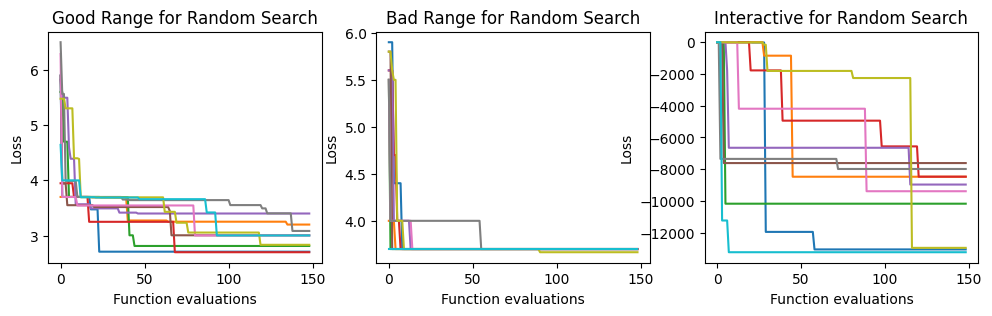

In [38]:
trails = 10

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,3))

for j in range(trails):
    losses,config = random_search("good_range")
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[0].plot(range(len(losses)-1),loss)   
    axs[0].title.set_text("Good Range for Random Search")
    
for j in range(trails):
    losses,config = random_search("bad_range")
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[1].plot(range(len(losses)-1),loss) 
    axs[1].title.set_text("Bad Range for Random Search")
    
for j in range(trails):
    losses,config = random_search("interactive")
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[2].plot(range(len(losses)-1),loss) 
    axs[2].title.set_text("Interactive for Random Search")
    
for ax in axs.flat:
    ax.set(xlabel='Function evaluations', ylabel='Loss')
plt.show()

In [ ]:
trails = 10

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,3))

for j in range(trails):
    df, bp,x, y, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2 = tpe2(problem='good_range', n=24,random_start = 10,gamma=0.1, function_evaluations= 150)
    losses = df['loss'].values.tolist()
    loss = []
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[0].plot(range(len(losses)-1),loss)   
    axs[0].title.set_text("Good Range for TPE")
    
for j in range(trails):
    df, bp,x, y, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2 = tpe2(problem='bad_range', n=24,random_start= 10,gamma=0.1, function_evaluations= 150)
    losses = df['loss'].values.tolist()
    loss = []
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[1].plot(range(len(losses)-1),loss) 
    axs[1].title.set_text("Bad Range for TPE")
    
for j in range(trails):
    df, bp,x, y, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2 = tpe2(problem='interactive',n=24,random_start= 10,gamma=0.1, function_evaluations= 150)
    losses = df['loss'].values.tolist()
    loss = []
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[2].plot(range(len(losses)-1),loss) 
    axs[2].title.set_text("Interactive for TPE")
    
for ax in axs.flat:
    ax.set(xlabel='Function evaluations', ylabel='Loss')
plt.show()

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.46573590279972

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.4334839232903

C:\Users\mally\AppData\Local\Temp\ipykernel_28500\4099214929.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))


3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511


C:\Users\mally\AppData\Local\Temp\ipykernel_28500\4099214929.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))


3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.4334839232903

3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.46573590

3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

C:\Users\mally\AppData\Local\Temp\ipykernel_28500\4099214929.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))


3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

C:\Users\mally\AppData\Local\Temp\ipykernel_28500\4099214929.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))


3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511


C:\Users\mally\AppData\Local\Temp\ipykernel_28500\4099214929.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))


3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

C:\Users\mally\AppData\Local\Temp\ipykernel_28500\4099214929.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))


3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155


C:\Users\mally\AppData\Local\Temp\ipykernel_28500\4099214929.py:150: RuntimeWarning: overflow encountered in double_scalars
  value = (gamma + (1-gamma)*(pd_lx/pd_gx))


3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.4334839232903

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.4334839232903

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.4334839

3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

C:\Users\mally\AppData\Local\Temp\ipykernel_28500\4099214929.py:120: RuntimeWarning: overflow encountered in divide
  plot = (gamma + (1-gamma)*(l_x/g_x))


-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.43348392329

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.465735902799

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.465735902799

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.4334839232903

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.46573590279972

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.46573590279972

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.46573590279972

3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.46573590279972

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.4

-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155


3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.465735902799

3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
3.4657359027997265 6.93537044601511
-9.433483923290392 -0.916290731874155
3.465735902799

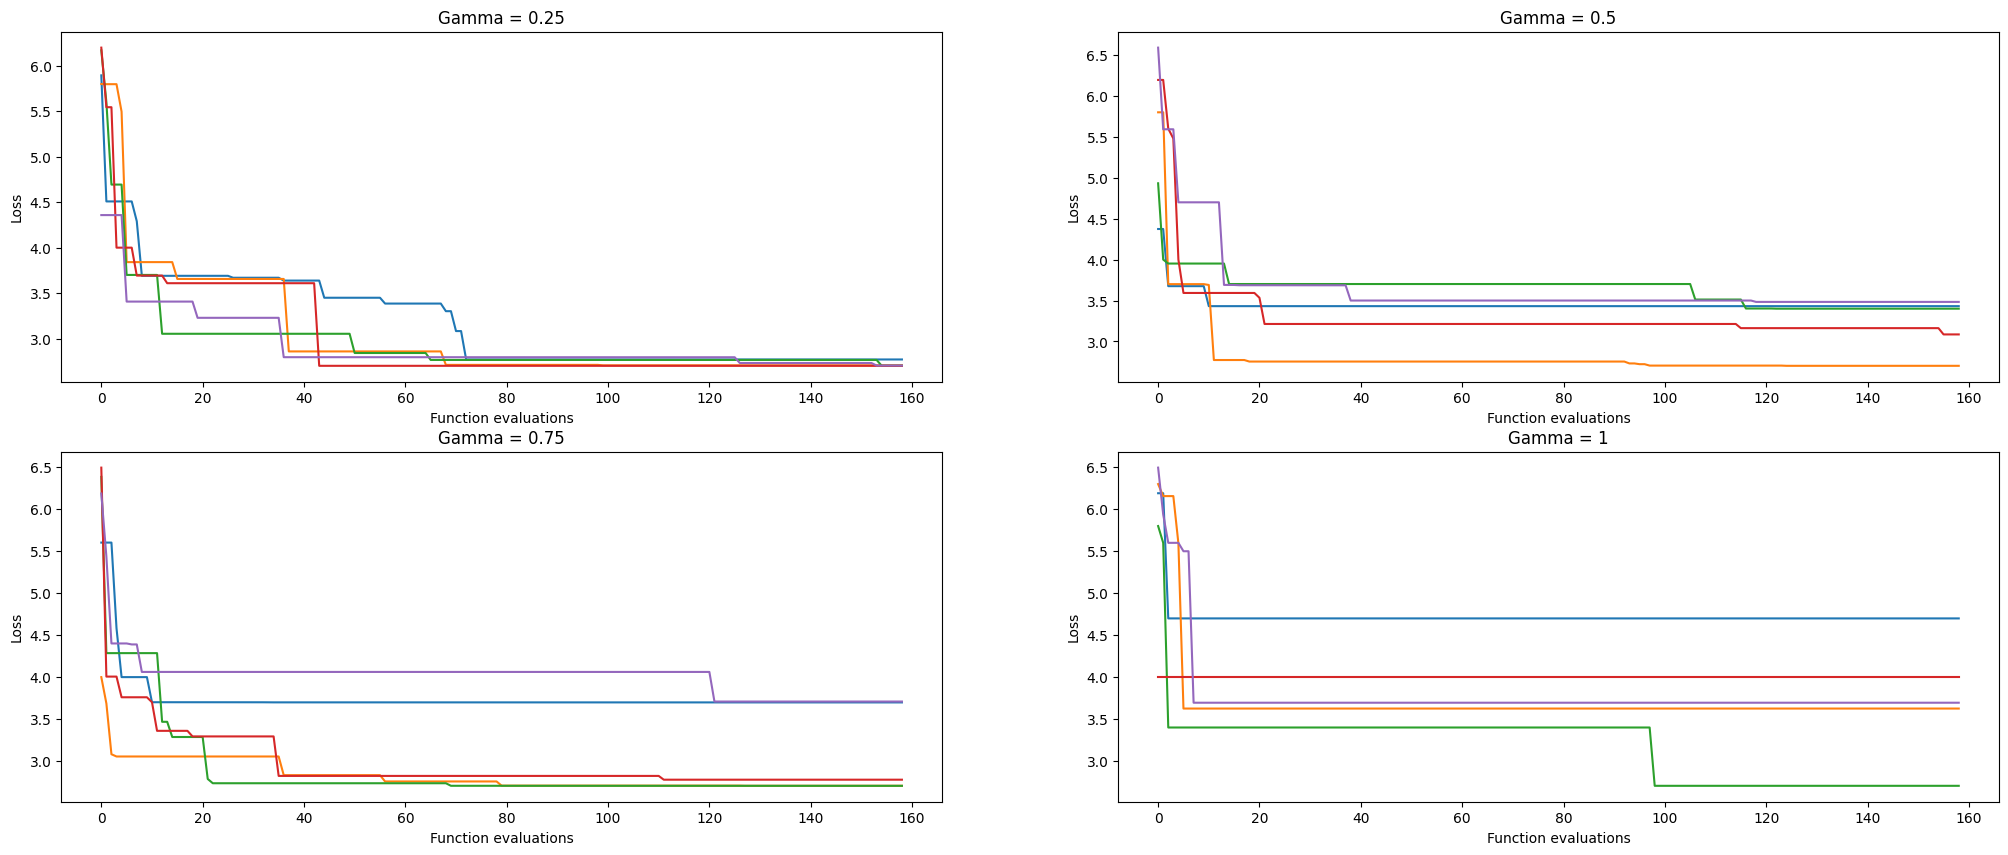

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

trails = 5


fig,axs1 = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
for j in range(trails):
    hyperparameters, bp,x, y, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2  = tpe2("good_range",gamma=0.25)
    losses = hyperparameters["loss"].values.tolist()
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs1[0][0].plot(range(len(losses)-1),loss)   
    axs1[0][0].title.set_text("Gamma = 0.25")

for j in range(trails):
    hyperparameters, bp,x, y, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2  = tpe2("good_range",gamma=0.5)
    losses = hyperparameters["loss"].values.tolist()
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs1[0][1].plot(range(len(losses)-1),loss)   
    axs1[0][1].title.set_text("Gamma = 0.5")
    
for j in range(trails):
    hyperparameters, bp,x, y, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2  = tpe2("good_range",gamma=0.75)
    losses = hyperparameters["loss"].values.tolist()
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs1[1][0].plot(range(len(losses)-1),loss)   
    axs1[1][0].title.set_text("Gamma = 0.75")

for j in range(trails):
    hyperparameters, bp,x, y, EI_plot1, EI_plot2,l_x_plot_h1,g_x_plot_h1,l_x_plot_h2,g_x_plot_h2 = tpe2("good_range",gamma=1)
    losses = hyperparameters["loss"].values.tolist()
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs1[1][1].plot(range(len(losses)-1),loss)   
    axs1[1][1].title.set_text("Gamma = 1")

for ax in axs1.flat:
    ax.set(xlabel='Function evaluations', ylabel='Loss')
plt.show()